In [1]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-11-12 16:31:01--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-11-12 16:31:01--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   115MB/s    in 0.7s    

2020-11-12 16:31:02 (115 MB/s) - ‘Minicon

In [2]:
import torch
from rdkit import Chem
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from torch.nn.functional import one_hot
from rdkit.Chem import RWMol

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':'1uLhZjDx04xp0o6kOM1aAFl0l89HSweLZ'})   # replace the id with id of file you want to access
downloaded.GetContentFile('gdb9_clean.sdf') 

In [5]:
## Global variables, used to initialise dataset class  
molecules = Chem.SDMolSupplier('/content/gdb9_clean.sdf',sanitize=True)

atom_set = ['C','O','N','F']
N        = 9 
atom_to_num  = dict({x:y for x,y in zip(atom_set,range(len(atom_set)))})

In [6]:
#### Molecule --> A,X

def mol_with_atom_index(mol):
  atoms = mol.GetNumAtoms()
  for idx in range(atoms):
    mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
  return mol


def bond_features(bond):
  bt = bond.GetBondType()
  return (torch.Tensor([bt == Chem.rdchem.BondType.SINGLE,\
                        bt == Chem.rdchem.BondType.DOUBLE,\
                        bt == Chem.rdchem.BondType.TRIPLE,\
                        bt == Chem.rdchem.BondType.AROMATIC]))


def array_to_atom(x):
  max_atoms = len(atom_set)
  idx  = np.dot(x.numpy(),np.array(range(0,max_atoms+1))).astype(int)
  if idx == max_atoms:
    return None
  else:
    atom = Chem.rdchem.Atom(atom_set[idx])
  return atom.GetAtomicNum()


def atom_features(mol):
  a_list = []
  max_atoms_types = len(atom_set)

  for atom in mol.GetAtoms():
    a_list.append(atom_to_num[atom.GetSymbol()])     

  a_list  = torch.tensor(a_list).type(torch.LongTensor)
  N_f_mat = one_hot(a_list,num_classes=max_atoms_types)
  n_atoms = N_f_mat.size()[0]
  N_f_mat = torch.cat([N_f_mat,torch.zeros((n_atoms,1))],dim=1)
  delta   = N - n_atoms

  if delta>0:
    pad = [[0]*max_atoms_types + [1] for _ in range(delta)]
    pad = torch.tensor(pad).type(torch.LongTensor)
    N_f_mat = torch.cat([N_f_mat,pad],dim=0)
  return N_f_mat

  ### A_ij = [1,0,0,0,0] - single   i,j are atoms i and j
  ###        [0,1,0,0,0] - double
  ###        [0,0,1,0,0] - triple
  ###        [0,0,0,1,0] - aromatic
  ###        [0,0,0,0,0] - No bond 

def adj_mat(mol):
  adjecency_mat = torch.zeros((N,N,4))
  for bond in mol.GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    adjecency_mat[start,end,:] = bond_features(bond)
    adjecency_mat[end,start,:] = bond_features(bond)
  return torch.cat([adjecency_mat,torch.zeros((N,N,1))],dim=-1)

##### A,X to molecule ###############################

def array_to_atom(x):
  max_atoms = len(atom_set)
  idx  = np.dot(x.numpy(),np.array(range(0,max_atoms+1))).astype(int)
  if idx == max_atoms:
    return 0
  else:
    atom = Chem.rdchem.Atom(atom_set[idx])
    return atom.GetAtomicNum()


def array_to_bond(x):
  if torch.sum(x).numpy() == 0:
    return None
  else:
    idx = np.dot(x.numpy(),np.array(range(0,5))).astype(int)
  return [Chem.rdchem.BondType.SINGLE,Chem.rdchem.BondType.DOUBLE,\
            Chem.rdchem.BondType.TRIPLE,Chem.rdchem.BondType.AROMATIC,None][idx]


def A_x_to_mol(A,x):

  mol = RWMol()
  n_atoms = x.size()[0]
  
  non_empty_atoms = []
  for i in range(n_atoms):
    if x[i,:][-1].numpy() != 1:
      mol.AddAtom(Chem.Atom(0))
      non_empty_atoms.append(i)

  for i in non_empty_atoms:
    for j in non_empty_atoms:
      bond = array_to_bond(A[i,j,:])
      if i>j and bond != None:
        mol.AddBond(i,j,bond)
  for i in non_empty_atoms:
    mol.GetAtomWithIdx(i).SetAtomicNum(array_to_atom(x[i,:]))
  return mol

### Encoding Tests

In [7]:
def result(mol):
  print('respective column',[(atom,atom_to_num[atom]) for atom in ['C','N','O','F']])
  print('Node Feature Matrix')
  print(atom_features(mol))

In [8]:
mol1 = Chem.MolFromSmiles('N\C(F)=C(\O)C#C')
mol2 = Chem.MolFromSmiles('C1=CC=CC=C1')
mol3 = Chem.MolFromSmiles('CC1CCC2CCCC12')

###Node Feature matrix computation 

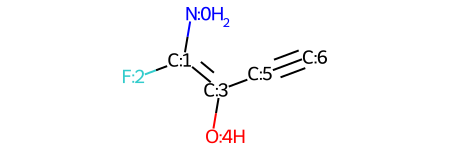

In [9]:
mol_with_atom_index(mol1)

In [10]:
result(mol1)

respective column [('C', 0), ('N', 2), ('O', 1), ('F', 3)]
Node Feature Matrix
tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])


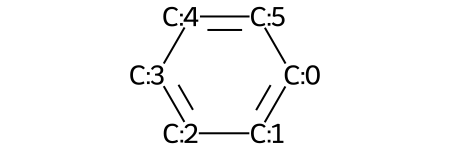

In [11]:
mol_with_atom_index(mol2)

In [12]:
result(mol2)

respective column [('C', 0), ('N', 2), ('O', 1), ('F', 3)]
Node Feature Matrix
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])


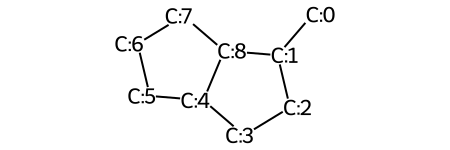

In [13]:
mol_with_atom_index(mol3)

In [14]:
result(mol3)

respective column [('C', 0), ('N', 2), ('O', 1), ('F', 3)]
Node Feature Matrix
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


### Adjacency tensor computation 

In [15]:
# Returns 0 if tensor is symetric 
def tensor_symmetry_check(A):
  return torch.sum(A-torch.transpose(A,0,1)).numpy() ## SYM MAT A = A^T --> A - A^T = 0

# Check for number of atoms <=9 that adjecency tensor is symmetric for all molecules
# in dataset 

In [16]:
counter = 0
for mol in molecules:
  if mol is None:
    continue
  try:
    Chem.SanitizeMol(mol) ### valid chem compound
    if tensor_symmetry_check(adj_mat(mol))!=0:
      print('Not symmetric tensor')
  except:
    continue

RDKit WARNING: [16:33:35] Warning: molecule is tagged as 3D, but all Z coords are zero


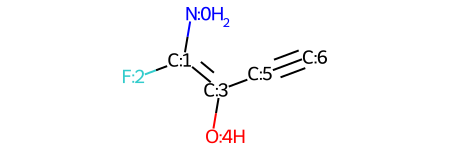

In [17]:
mol_with_atom_index(mol1)

In [18]:
A = adj_mat(mol1)

In [19]:
print('single bond 0-1',A[0,1,:])
print('double bond 1-3',A[1,3,:])
print('triple bond 5-6',A[5,6,:])
print('No bond 2-4',A[2,4,:])

single bond 0-1 tensor([1., 0., 0., 0., 0.])
double bond 1-3 tensor([0., 1., 0., 0., 0.])
triple bond 5-6 tensor([0., 0., 1., 0., 0.])
No bond 2-4 tensor([0., 0., 0., 0., 0.])


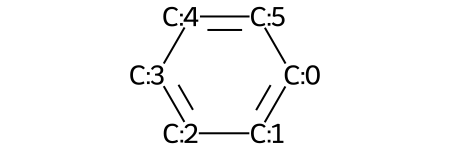

In [20]:
mol_with_atom_index(mol2)

In [21]:
A2 = adj_mat(mol2)
print('aromatic bond 2-3',A2[2,3,:])

aromatic bond 2-3 tensor([0., 0., 0., 1., 0.])


### Decoding test   
### molecule --> A,X --> molecule 

In [22]:
def array_to_atom(x):
  max_atoms = len(atom_set)
  idx  = np.dot(x.numpy(),np.array(range(0,max_atoms+1))).astype(int)
  if idx == max_atoms:
    return 0
  else:
    atom = Chem.rdchem.Atom(atom_set[idx])
    return atom.GetAtomicNum()


def array_to_bond(x):
  if torch.sum(x).numpy() == 0:
    return None
  else:
    idx = np.dot(x.numpy(),np.array(range(0,5))).astype(int)
  return [Chem.rdchem.BondType.SINGLE,Chem.rdchem.BondType.DOUBLE,\
            Chem.rdchem.BondType.TRIPLE,Chem.rdchem.BondType.AROMATIC,None][idx]


def A_x_to_mol(A,x):

  mol = RWMol()
  n_atoms = x.size()[0]
  
  non_empty_atoms = []
  for i in range(n_atoms):
    if x[i,:][-1].numpy() != 1:
      mol.AddAtom(Chem.Atom(0))
      non_empty_atoms.append(i)

  for i in non_empty_atoms:
    for j in non_empty_atoms:
      bond = array_to_bond(A[i,j,:])
      if i>j and bond != None:
        mol.AddBond(i,j,bond)
  for i in non_empty_atoms:
    mol.GetAtomWithIdx(i).SetAtomicNum(array_to_atom(x[i,:]))
  return mol

In [23]:
def inverse(mol):
  A,X = adj_mat(mol), atom_features(mol)
  mol_inverse = A_x_to_mol(A,X)
  return mol_with_atom_index(mol_inverse)

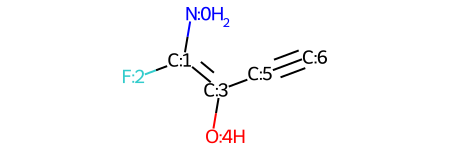

In [24]:
mol_with_atom_index(mol1)

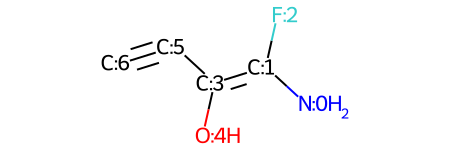

In [25]:
inverse(mol1)

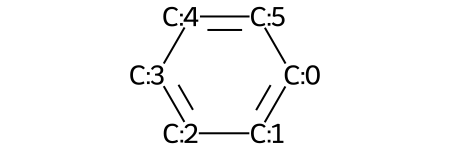

In [26]:
mol_with_atom_index(mol2)

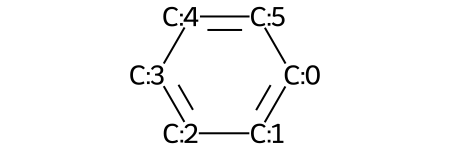

In [27]:
inverse(mol2)